In [68]:
!gdown --id 1j2V-P2NtROo9Mw0Wyyo6EWi78JrzaMgl
!gdown --id 1nS28sVEl2hEsLpAqjnx772x9p9bh2IYf
!gdown --id 1jQTlWqNtv8PPpLw1iU5F6MFbNrwk_Oj2
!gdown --id 1-NNSE5bcjkhOHNTIWfgIVxz0rdci1DNR
!git clone https://github.com/Po-Hsun-Su/pytorch-ssim.git "ssim_loss"

Downloading...
From: https://drive.google.com/uc?id=1j2V-P2NtROo9Mw0Wyyo6EWi78JrzaMgl
To: /content/img_list.npy
100% 101M/101M [00:00<00:00, 163MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1nS28sVEl2hEsLpAqjnx772x9p9bh2IYf
To: /content/mask_list.npy
100% 33.7M/33.7M [00:00<00:00, 157MB/s]
Downloading...
From: https://drive.google.com/uc?id=1jQTlWqNtv8PPpLw1iU5F6MFbNrwk_Oj2
To: /content/model.state
100% 33.6M/33.6M [00:00<00:00, 156MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-NNSE5bcjkhOHNTIWfgIVxz0rdci1DNR
To: /content/mask_list_new.npy
100% 33.7M/33.7M [00:00<00:00, 104MB/s] 
fatal: destination path 'ssim_loss' already exists and is not an empty directory.


In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import os

import matplotlib.pyplot as plt

from PIL import Image
import numpy as np

import pandas as pd

from torch.utils.data import Dataset, DataLoader

from ssim_loss.pytorch_ssim import ssim

class BacteriaDataset(Dataset):
  def __init__(self, path = ""):
    img_list_path = os.path.join(path, "img_list.npy")
    mask_list_path = os.path.join(path, "mask_list_new.npy")

    self.img_list = np.load(img_list_path)
    self.mask_list = np.load(mask_list_path)

  def __len__(self):
    return len(self.img_list)

  def __getitem__(self, idx):
    return {"image": torch.tensor(self.img_list[idx]), "mask": torch.tensor(self.mask_list[idx])}


def create_dataloaders(path = ""):
  ds = BacteriaDataset(path)

  train_ds, test_ds = torch.utils.data.random_split(ds, (3000, 660))

  train_loader = DataLoader(train_ds, batch_size = 32, drop_last = True, shuffle = True)
  test_loader = DataLoader(test_ds, batch_size = 32, drop_last = True, shuffle = True)

  return train_loader, test_loader

def ssim_loss(image, target):

  loss = 1 - ssim(image, target)

  return loss


def display_data(images, prediction = None, target = None):
  images = images.permute(0, 2, 3, 1)

  images = images.detach().numpy()

  if prediction is not None:
    prediction = prediction.detach().numpy()

  if target is not None:
    target = target.detach().numpy()

  # settings
  h, w = 48, 48        # for raster image


  nrows = 3            # array of sub-plots
  figsize = [7, 7]     # figure size, inches

  if prediction is None and target is None:
    ncols = 1
  elif prediction is not None and target is not None:
    ncols = 3
  else:
    ncols = 2

  # create figure (fig), and array of axes (ax)
  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

  # plot simple raster image on each sub-plot
  for i, axi in enumerate(ax.flat):
    if i >= ncols * 9:
      break

    rowid = i // ncols
    colid = i % ncols

    # i runs from 0 to (nrows*ncols-1)
    # axi is equivalent with ax[rowid][colid]
    if colid == 0:
      img = images[rowid]
      un = UnNormalize((0.1572, 0.1931, 0.2520), (0.1855, 0.2122, 0.2128))
      img = un(torch.tensor(img))
      img = torch.clip(img, 0.0, 1.0)
      axi.imshow(img.squeeze(), alpha=1)

    un = UnNormalize((0.0007, ), (0.0015, ))
    if colid == 1:
      pred = -1 * prediction[rowid]
      #pred = un(torch.tensor(pred))
      axi.imshow(pred.squeeze(), cmap='Greys', alpha = 1)

    if colid == 2:
      tar = target[rowid]
      #tar = un(torch.tensor(tar))
      axi.imshow(tar.squeeze(), cmap='Greys', alpha = 1)
  

  plt.tight_layout(True)
  plt.show()

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

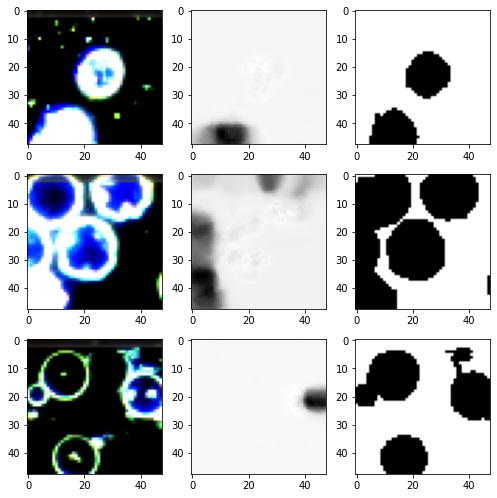

Loss: 0.018060743808746338


In [93]:
class BacteriaModel(torch.nn.Module):
  def __init__(self):
    super(BacteriaModel, self).__init__()

    # Convolutional Layers
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 7, padding = 3)
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 36, kernel_size = 5, padding = 2)
    self.conv3 = nn.Conv2d(in_channels = 36, out_channels = 100, kernel_size = 5, padding = 2)

    # Linear Layers
    self.linear1 = nn.Linear(3600, 48 * 48)

    # Helper Layers
    self.pool = nn.MaxPool2d(2, 2)
    self.relu = nn.ReLU()

    self.batch_norm1 = nn.BatchNorm2d(6)
    self.batch_norm2 = nn.BatchNorm2d(36)
    self.batch_norm3 = nn.BatchNorm2d(100)

  def forward(self, image):
    image = self.conv1(image)
    image = self.batch_norm1(self.relu(self.pool(image)))
    image = self.conv2(image)
    image = self.batch_norm2(self.relu(self.pool(image)))
    image = self.conv3(image)
    image = self.batch_norm3(self.relu(self.pool(image)))

    image = image.view(32, -1)
    image = self.linear1(image)
    image = image.view(-1, 1, 48, 48)

    return image

def train(model, train_dataset, optim):
  for epoch_number in range(1, 51):
    total_training_loss = 0

    for batch in train_dataset:
      optim.zero_grad()
      
      images = batch["image"]
      masks = batch["mask"]

      prediction = model(images)

      loss = ssim_loss(masks, prediction)

      total_training_loss += loss.item()

      loss.backward()
      optim.step()
    
    total_training_loss /= len(train_dataset)

    print(f"epoch {epoch_number}: loss {total_training_loss}")

    if epoch_number % 5 == 0:
      torch.save(model.state_dict(), "model.state")

def test(model, test_dataset):
  total_test_loss = 0
  for batch in test_dataset:
    
    images = batch["image"]
    masks = batch["mask"]

    prediction = model(images)

    loss = ssim_loss(masks, prediction)

    total_test_loss += loss.item()

    #display_data(images)
    #display_data(images, prediction)
    display_data(images, prediction, masks)

    break
  
  total_test_loss /= len(test_dataset)
  print(f"Loss: {total_test_loss}")

if __name__ == "__main__":
  train_loader, test_loader = create_dataloaders()

  # Model
  model = BacteriaModel()
  model.load_state_dict(torch.load("model.state"))

  # Optimizer
  optim = torch.optim.Adam(model.parameters())

  #train(model, train_loader, optim)

  test(model, test_loader)